In [1]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sns.set_style("ticks")
sns.set()
sns.set_color_codes()

def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

In [141]:
aggregate_root = '/n/coxfs01/cechavarria/2p-aggregate/scenes'

# sess_list = ['JC097_20190621','JC085_20190624','JC097_20190628','JC097_20190704','JC085_20190712']
# area = 'V1'

# sess_list = ['JC080_20190619','JC091_20190621','JC091_20190628','JC097_20190702','JC091_20190703','JC085_20190704','JC097_20190708']
# area = 'LM'

sess_list = ['JC091_20190625','JC091_20190701','JC091_20190705']
area = 'LI'


response_type = 'norm_df'
filter_crit = 'zscore'
filter_thresh = 1

# filter_crit = 'split_half_R'
# filter_thresh = .6

if ('norm' in response_type) or ('std' in response_type):
    i1 = findOccurrences(response_type,'_')[-1]
    fetch_data = response_type[i1+1:]
else:
    fetch_data = response_type
print(fetch_data)

#define paths
aggregate_file_dir = os.path.join(aggregate_root,area,'files')
fig_out_dir = os.path.join(aggregate_root,area,'figures')

if not os.path.isdir(fig_out_dir):
        os.makedirs(fig_out_dir)
        

df


In [142]:
#pool all neurons


#put things into pandas df for plotting
resp_dfs = []

animalids = []
sess_count = []
active_cell_count = 0
total_cell_count = 0
active_cells_per_img_count = np.zeros((60,))

ylabel = 'Average Response'

for sess_idx, sess in enumerate(sess_list):
    # sess_idx = 0
    # sess = sess_list[sess_idx]
    print(sess)
    i1 = findOccurrences(sess,'_')[0]
    animalid = sess[0:i1]
    session = sess[i1+1:]


    if animalid not in animalids:
        animalids.append(animalid)
        sess_count.append(0)

    animal_idx = animalids.index(animalid)
    sess_count[animal_idx] = sess_count[animal_idx]+1

    #load data
    aggregate_file_dir = os.path.join(aggregate_root,area,'files','trial_responses')
    data_array_fn = '%s_%s_trial_response_array.hdf5'%(animalid, session)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')

    cell_rois = data_grp.attrs['s2p_cell_rois']

    curr_slice = 'Slice01'#hard,coding for now

    #unpack
    response_matrix = np.array(data_grp['/'.join([curr_slice, 'responses' ,fetch_data])])

    filter_crit_matrix_trials = np.array(data_grp['/'.join([curr_slice, 'responses' ,filter_crit])])

    #considering only cell rois
    response_matrix = response_matrix[:,:,cell_rois]
    ntrials,nconfigs,nrois = response_matrix.shape


    if filter_crit == 'zscore':
        filter_crit_matrix_trials = filter_crit_matrix_trials[:,:,cell_rois]
        filter_crit_matrix_mean = np.squeeze(np.mean(filter_crit_matrix_trials,0))
    elif filter_crit == 'simple_pval' or filter_crit == 'paired_pval' or filter_crit == 'perm_p' or 'stat' in filter_crit:
        filter_crit_matrix_mean = filter_crit_matrix_trials[:,cell_rois]
    elif filter_crit == 'split_half_R':
        filter_crit_matrix_mean = filter_crit_matrix_trials[cell_rois]

    data_grp.close()

    #avg over trials

    mean_response_matrix = np.mean(response_matrix,0)
    #split data into half by selecting odd or even trials
    mean_response_matrix_half1 = np.mean(response_matrix[0:ntrials:2,:,:],0)
    mean_response_matrix_half2 = np.mean(response_matrix[1:ntrials:2,:,:],0)

    #consider a config active if at least one of theversion of an image evoked a response above threshol

    if filter_crit == 'zscore' or 'tstat' in filter_crit:
        thresh = filter_thresh
        thresh_matrix = filter_crit_matrix_mean>thresh
    elif filter_crit == 'simple_pval' or filter_crit == 'paired_pval' or filter_crit == 'perm_p':
        thresh = filter_thresh
        thresh_matrix = np.logical_and(filter_crit_matrix_mean<thresh,filter_crit_matrix_mean>0)
    elif filter_crit == 'split_half_R':
        thresh = filter_thresh
        thresh_matrix= filter_crit_matrix_mean>thresh
        thresh_matrix = np.expand_dims(thresh_matrix,0)
        thresh_matrix = np.tile(thresh_matrix,(nconfigs,1))

    filter_matrix = np.ones((thresh_matrix.shape))*np.nan
    active_rois_per_config = np.nansum(thresh_matrix,1)
    for ridx in range(nrois):
        for idx in range(0,thresh_matrix.shape[0],3):
                if np.sum(thresh_matrix[idx:idx+3,ridx])>0:
                    filter_matrix[idx:idx+3,ridx] = 1
                    
#     filter_matrix = np.ones((thresh_matrix.shape))*np.nan
#     active_rois_per_config = np.nansum(thresh_matrix,1)
#     for ridx in range(nrois):
#         for idx in range(0,thresh_matrix.shape[0],3):
#                 if np.sum(thresh_matrix[idx:idx+3,ridx])>0:
#                     filter_matrix[:,ridx] = 1
    active_rois_per_img = np.nansum(filter_matrix,1)
        

    #figure out some activity details
    active_cell_idx = np.nansum(filter_matrix,0)>0
    num_active_rois = np.nansum(np.nansum(filter_matrix,0)>0)
    frac_active_rois = num_active_rois/float(len(cell_rois))
    print('# active rois = %i'%(num_active_rois))
    print('frac active rois = %.04f'%(frac_active_rois))

    #normalize across configs within cell, if necessary
    if 'norm' in response_type:
        norm_response_array = np.empty((nconfigs,nrois))

        for ridx in range(nrois):
            norm_response_array[:,ridx] = mean_response_matrix[:,ridx]/np.nanmax(mean_response_matrix[:,ridx])
        mean_response_matrix = norm_response_array
    if 'std' in response_type:#standardise response by z-scoring across configs
        std_response_array = np.empty((nconfigs,nrois))

        for ridx in range(nrois):
            std_response_array[:,ridx] = (mean_response_matrix[:,ridx]-np.nanmean(mean_response_matrix[:,ridx]))/np.nanstd(mean_response_matrix[:,ridx])
        mean_response_matrix = std_response_array

    filt_response_array = mean_response_matrix*filter_matrix
    
    total_cell_count = total_cell_count + active_cell_idx.shape[0]
    active_cell_count = active_cell_count + np.nansum(active_cell_idx)
    active_cells_per_img_count = active_cells_per_img_count + active_rois_per_img
    print(active_cell_count)



    if sess_idx == 0:
        response_array = filt_response_array[:,active_cell_idx]
    else:
        response_array = np.hstack((response_array,filt_response_array[:,active_cell_idx]))

JC091_20190625
# active rois = 79
frac active rois = 0.5302
79
JC091_20190701


/home/cesar/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in greater
/home/cesar/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide


# active rois = 17
frac active rois = 0.1308
96
JC091_20190705
# active rois = 59
frac active rois = 0.6344
155


In [143]:
mod_idx = np.zeros(response_array.shape)
for ridx in range(response_array.shape[1]): 
    for cond_idx in range(0,nconfigs,3):
        if not np.isnan(response_array[cond_idx,ridx]):
            #tex - sf
            mod_idx[cond_idx,ridx] = np.true_divide(response_array[cond_idx+2,ridx] - response_array[cond_idx+1,ridx],\
                                                    response_array[cond_idx+2,ridx] + response_array[cond_idx+1,ridx])
            #orig - sf
            mod_idx[cond_idx+1,ridx] = np.true_divide(response_array[cond_idx,ridx] - response_array[cond_idx+1,ridx],\
                                                    response_array[cond_idx,ridx] + response_array[cond_idx+1,ridx])
            #orig - tex
            mod_idx[cond_idx+2,ridx] = np.true_divide(response_array[cond_idx,ridx] - response_array[cond_idx+2,ridx],\
                                                    response_array[cond_idx,ridx] + response_array[cond_idx+2,ridx])
        else:
            mod_idx[cond_idx:cond_idx+3,ridx] = np.nan


In [145]:
tmp = np.arange(0,3)
config_cond = np.tile(tmp,20)

config_img = np.ones((3,))
for img in range(2,21):
    config_img = np.hstack((config_img,np.ones((3,))*img))

#averaging difference/ modulation index across active neurons (1 active condition) - group by image
mean_mod_idx = np.nanmean(mod_idx,1)
se_mod_idx = np.true_divide(np.nanstd(mod_idx,1),np.sqrt(active_cells_per_img_count))

title_list = ['Mid_vs_Low_Complexitiy','Original_vs_Low Complexiity','Original_vs_Mid_Complexity']
for cidx in range(len(title_list)):
    #cidx = 0     
    #modulation index figure
    cfg_idxs = np.where(config_cond==cidx)[0]

    fig = plt.figure(figsize=(15,5))

    plt.bar(config_img[cfg_idxs],mean_mod_idx[cfg_idxs],yerr = se_mod_idx[cfg_idxs])
    #plot unity
    axes = plt.gca()
    xmin, xmax = axes.get_xlim()
    ymin, ymax = axes.get_ylim()
    plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')
    for idx in cfg_idxs:
        plt.text(config_img[idx]-.25, ymax, 'n=%i' % active_cells_per_img_count[idx], fontsize=10)
    plt.xticks(config_img[cfg_idxs].tolist())
    plt.xlabel('Image',fontsize = 15)
    plt.ylabel('Modulation Index',fontsize = 15)
    plt.suptitle(title_list[cidx],fontsize = 15)

    fig_fn = '%s_mod_idx_%s_thresh_%s_%i.pdf'%(title_list[cidx],response_type,filter_crit,filter_thresh)


    fig_file_path = os.path.join(fig_out_dir, fig_fn)
    plt.savefig(fig_file_path)
    plt.close()

In [115]:
config_img[45:]

array([15., 15., 15., 16., 16., 16., 17., 17., 17., 18., 18., 18., 19.,
       19., 19.])

In [116]:
print(response_mean_per_config[45:])

[ 0.57018401  0.48650672  0.45366956  0.14738903  0.16775622  0.08253803
 -0.0384265  -0.00924158 -0.01303139  0.13091224  0.22296552  0.16873924
  0.53853287  0.47098687  0.44448826]


In [66]:
#average over neurons
response_mean_per_config = np.nanmean(response_array,1)

#SHIFTING ORDER OF CONDITIONS - for intuitive arrangement
response_cond_grouped = np.vstack((response_mean_per_config[0:nconfigs:3],\
                                  response_mean_per_config[2:nconfigs:3],\
                                  response_mean_per_config[1:nconfigs:3]))

In [67]:
frac_active_cells = active_cell_count/float(total_cell_count)

#average over images
response_per_cond_mean = np.nanmean(response_cond_grouped,1)
response_per_cond_se = np.nanstd(response_cond_grouped,1)/np.sqrt((nconfigs/3))

In [68]:
response_per_cond_mean

array([0.25704893, 0.23358136, 0.2614865 ])

In [69]:
stats.f_oneway(response_cond_grouped[0,:],response_cond_grouped[1,:],response_cond_grouped[2,:])

F_onewayResult(statistic=0.15141912881625702, pvalue=0.8598319579019401)

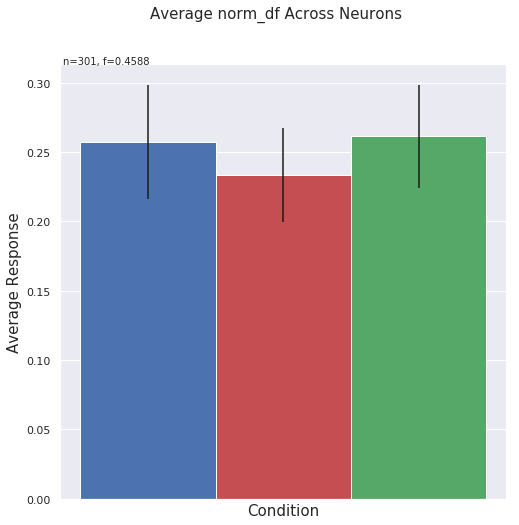

In [70]:
bar_loc = np.zeros((3,))
width = 0.4         # the width of the bars
xloc = 1
count = 0

for j in range(3):
    bar_loc[count] = xloc
    xloc = xloc + width
    count = count+1

fig = plt.figure(figsize=(8,8))
plt.bar(bar_loc[0],response_per_cond_mean[0],width,color = 'b',yerr = response_per_cond_se[0])
plt.bar(bar_loc[1],response_per_cond_mean[1],width,color = 'r',yerr = response_per_cond_se[1])
plt.bar(bar_loc[2],response_per_cond_mean[2],width,color = 'g',yerr = response_per_cond_se[2])

axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')

xtick_loc = []
xtick_label = []

plt.xticks(xtick_loc,xtick_label)
plt.xlabel('Condition',fontsize = 15)
plt.ylabel('Average Response',fontsize = 15)
plt.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)


plt.text(bar_loc[0]-.25, ymax, 'n=%i, f=%.04f' % (active_cell_count, frac_active_cells), fontsize=10)


fig_fn = '%s_avg_response_per_cond_across_images_%s_thresh_%s_%.02f.png'%(area,response_type,filter_crit,filter_thresh)

fig_file_path = os.path.join(fig_out_dir, fig_fn)
#plt.savefig(fig_file_path)
#plt.close()

In [ ]:
active_cells_per_img_count

In [116]:

ylabel = 'Average Response'

resp_dfs = []
for cidx in range(response_array.shape[0]):
    response = response_array[cidx,:]
    cell = np.arange(active_cell_count)
    cond = np.ones((active_cell_count,))*cidx
    mdf = pd.DataFrame({'%s' % ylabel: response,
                        'response': response,
                        'cell': cell,
                        'cond': cond,
                       })

    resp_dfs.append(mdf)
resp_dfs = pd.concat(resp_dfs, axis=0)

bar_loc = np.arange(0,3)
width = 0.5

palette = sns.color_palette(["#4c72b0","#c44e52","#55a868"])
sns.set_palette(palette)

p = sns.catplot(x='cond', y='response', kind="swarm", hue = 'cond',data=resp_dfs,size = 10);

axes = p.ax
ymin,ymax = axes.get_ylim()
xmin,xmax = axes.get_xlim()

for idx in range(3):
    p.ax.hlines(y = response_per_cond_mean[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=2, color='k',linestyle = '-')
    p.ax.hlines(y = response_per_cond_mean[idx] + response_per_cond_se[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')
    p.ax.hlines(y = response_per_cond_mean[idx] - response_per_cond_se[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')




p.ax.set_xticks(())
p.ax.set_xlabel('Condition',fontsize = 15)
p.ax.set_ylabel('Average Response',fontsize = 15)
p.fig.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)


p.ax.text(bar_loc[0]-.25, ymax, 'n=%i, f=%.04f' % (active_cell_count, frac_active_cells), fontsize=10)


fig_fn = '%s_avg_response_per_cond_scatter_neurons_%s_thresh_%s_%.02f.png'%(area,response_type,filter_crit,filter_thresh)

fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)

plt.close()


/home/cesar/envs/suite2p/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


In [18]:
#randomply split data and plot

half1_idxs = np.arange(0,response_array.shape[1],2)
half2_idxs = np.arange(1,response_array.shape[1],2)
half_cells = half1_idxs.size

response_array_half1 = response_array[:,half1_idxs]
response_array_half2 = response_array[:,half2_idxs]

response_per_cond_half1_mean = np.nanmean(response_array_half1,1)
response_per_cond_half2_mean = np.nanmean(response_array_half2,1)

response_per_cond_half1_se = np.nanstd(response_array_half1,1)/np.sqrt(half_cells)
response_per_cond_half2_se = np.nanstd(response_array_half2,1)/np.sqrt(half_cells)


bar_loc = np.zeros((3,))
width = 0.4         # the width of the bars
xloc = 1
count = 0

for j in range(3):
    bar_loc[count] = xloc
    xloc = xloc + width
    count = count+1

fig = plt.figure(figsize=(8,8))
plt.bar(bar_loc[0],response_per_cond_half1_mean[0],width,color = 'b',yerr = response_per_cond_half1_se[0])
plt.bar(bar_loc[1],response_per_cond_half1_mean[1],width,color = 'r',yerr = response_per_cond_half1_se[1])
plt.bar(bar_loc[2],response_per_cond_half1_mean[2],width,color = 'g',yerr = response_per_cond_half1_se[2])

axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')

xtick_loc = []
xtick_label = []

plt.xticks(xtick_loc,xtick_label)
plt.xlabel('Condition',fontsize = 15)
plt.ylabel('Average Response',fontsize = 15)
plt.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)


plt.text(bar_loc[0]-.25, ymax, 'n=%i' % (half_cells), fontsize=10)


fig_fn = '%s_half1_avg_response_per_cond_across_neurons_%s_thresh_%s_%.02f.png'%(area,response_type,filter_crit,filter_thresh)

fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)
plt.close()



fig = plt.figure(figsize=(8,8))
plt.bar(bar_loc[0],response_per_cond_half2_mean[0],width,color = 'b',yerr = response_per_cond_half2_se[0])
plt.bar(bar_loc[1],response_per_cond_half2_mean[1],width,color = 'r',yerr = response_per_cond_half2_se[1])
plt.bar(bar_loc[2],response_per_cond_half2_mean[2],width,color = 'g',yerr = response_per_cond_half2_se[2])

axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')

xtick_loc = []
xtick_label = []

plt.xticks(xtick_loc,xtick_label)
plt.xlabel('Condition',fontsize = 15)
plt.ylabel('Average Response',fontsize = 15)
plt.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)


plt.text(bar_loc[0]-.25, ymax, 'n=%i' % (half_cells), fontsize=10)


fig_fn = '%s_half2_avg_response_per_cond_across_neurons_%s_thresh_%s_%.04f.png'%(area,response_type,filter_crit,filter_thresh)

fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)
plt.close()

In [ ]:

ylabel = 'Average Response'

resp_dfs = []
for cidx in range(response_array.shape[0]):
    response = response_array[cidx,:]
    cell = np.arange(active_cell_count)
    cond = np.ones((active_cell_count,))*cidx
    mdf = pd.DataFrame({'%s' % ylabel: response,
                        'response': response,
                        'cell': cell,
                        'cond': cond,
                       })

    resp_dfs.append(mdf)
resp_dfs = pd.concat(resp_dfs, axis=0)

bar_loc = np.arange(0,3)
width = 0.5

palette = sns.color_palette(["#4c72b0","#55a868","#c44e52"])
sns.set_palette(palette)

p = sns.catplot(x='cond', y='response', kind="swarm", hue = 'cond',data=resp_dfs,size = 10);

axes = p.ax
ymin,ymax = axes.get_ylim()
xmin,xmax = axes.get_xlim()

for idx in range(3):
    p.ax.hlines(y = response_per_cond_mean[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=2, color='k',linestyle = '-')
    p.ax.hlines(y = response_per_cond_mean[idx] + response_per_cond_se[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')
    p.ax.hlines(y = response_per_cond_mean[idx] - response_per_cond_se[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')




p.ax.set_xticks(())
p.ax.set_xlabel('Condition',fontsize = 15)
p.ax.set_ylabel('Average Response',fontsize = 15)
p.fig.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)


p.ax.text(bar_loc[0]-.25, ymax, 'n=%i, f=%.04f' % (active_cell_count, frac_active_cells), fontsize=10)


fig_fn = '%s_avg_response_per_cond_scatter_neurons_%s_thresh_%s_%i.png'%(area,response_type,filter_crit,filter_thresh)

fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)

plt.close()


In [ ]:
data_grp.close()

In [ ]:
#make figure
trace_labels = ['Original','Sf-Match','Corr-Match']
fig_fn = 'avg_trace_per_session_%s_%s_thresh_%s_%i.png'%(area, response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir,fig_fn)


p = sns.FacetGrid(sess_dfs, row = 'animalid',col = 'session', hue='stim_cond', size=10)
p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5)
p = p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1)
pl.subplots_adjust(wspace=0.1, hspace=0.8, top=0.85, bottom=0.1, left=0.1)

axes = p.axes
ymin,ymax = axes[0][0].get_ylim()
xmin,xmax = axes[0][0].get_xlim()
start_val = 0.0
end_val = 1.0 #hard-coding
for ri in range(p.axes.shape[0]):
    for ci in range(p.axes.shape[1]):
            #print ri, ci
            p.axes[ri,ci].add_patch(patches.Rectangle((start_val, ymin), end_val, ymax-ymin, linewidth=0, fill=True, color='k', alpha=0.2))
            p.axes[ri,ci].text(-0.999, ymax+(ymax*0), 'n=%i, f = %.04f' % (neuron_count[ri,ci],neuron_frac[ri,ci]), fontsize=10)
            p.axes[ri,ci].axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '--')

            if ri == 0:
              #  p.axes[ri].yaxis.set_major_locator(pl.MaxNLocator(2))
                p.axes[ri,ci].set_xticks(())
                sns.despine(trim=True, offset=0, bottom=True, left=False, ax=p.axes[ri,ci])
                p.axes[ri,ci].set_xlabel('time (s)', fontsize=8)
                p.axes[ri,ci].set_ylabel('%s' % ylabel, fontsize=8)
            else:
                sns.despine(trim=True, offset=0, bottom=True, left=True, ax=p.axes[ri,ci])
                p.axes[ri,ci].tick_params(
                                        axis='both',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom='off',      # ticks along the bottom edge are off
                                        left='off',
                                        top='off',         # ticks along the top edge are off
                                        labelbottom='off',
                                        labelleft='off') # labels along the bottom edge are off)
                p.axes[ri,ci].set_xlabel('')
                p.axes[ri,ci].set_ylabel('')
pl.legend(bbox_to_anchor=(0, -0.3), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=8)
p.savefig(fig_file_path)
plt.close()

In [ ]:
#put things into pandas df for plotting


ylabel = 'Normalized Response'

for sess_idx, sess in enumerate(sess_list):
    print(sess)
#     sess_idx = 0
#     sess = sess_list[sess_idx]
    i1 = findOccurrences(sess,'_')[0]
    animalid = sess[0:i1]
    session = sess[i1+1:]

    if animalid not in animalids:
        animalids.append(animalid)
        sess_count.append(0)

    sess_count[animalids.index(animalid)] = sess_count[animalids.index(animalid)]+1

    data_array_fn = '%s_filtered_%s_traces_thresh_%s_%i.hdf5'%(sess, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')

    if sess_idx == 0:
        frames_tsec = np.array(data_grp.attrs['frames_tsec'])


    curr_slice = 'Slice01'#hard-code planar data for now

    sess_trace = np.array(data_grp['/'.join([curr_slice, 'filtered_trace_per_cond_per_neuron_mean_across_images'])])

    #store in array
    if sess_idx == 0:
        trace_array = sess_trace
    else:
        #pad array with nan if necessary
        if sess_trace.shape[0]<trace_array.shape[0]:
            sess_trace = np.pad(sess_trace,((0,1),(0,0),(0,0)),'constant',constant_values = (0,np.nan))

        trace_array = np.dstack((trace_array,sess_trace))


data_grp.close()


In [ ]:
#get some activity stats
n_total_cells = trace_array.shape[2]
n_active_cells = np.sum(np.logical_not(np.isnan(trace_array[0,0,:])))
frac_active_cells = n_active_cells/float(n_total_cells)

In [ ]:
trace_array_mean = np.nanmean(trace_array,2)
trace_array_se = np.nanstd(trace_array,2)/np.sqrt(n_active_cells)

In [ ]:
#put things into pandas df for plotting
conddfs = []
ylabel = 'Normalized Response'
#cfg_key = 'config001'
for cond_count in range(trace_array_mean.shape[1]):
    stim_cond = cond_count
    mean_trace = trace_array_mean[:,cond_count]
    sem_trace = trace_array_se[:,cond_count]
    nreps = n_active_cells
    cdf = pd.DataFrame({'%s' % ylabel: mean_trace,
                        'tsec': frames_tsec,
                        'sem': sem_trace,
                       'fill_minus': mean_trace - sem_trace,
                        'fill_plus': mean_trace + sem_trace,
                        'stim_cond' : [stim_cond for _ in range(len(mean_trace))],
                       'nreps': [nreps for _ in range(len(mean_trace))]
                       })

    conddfs.append(cdf)
conddfs = pd.concat(conddfs, axis=0)

In [ ]:
fig_fn = 'avg_trace_across_all_active_cells_%s_%s_thresh_%s_%i.png'%(area, response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir,fig_fn)

#make figure
p = sns.FacetGrid(conddfs, hue='stim_cond', size=10)
p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5)
p = p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1)


axes = p.ax
ymin,ymax = axes.get_ylim()
xmin,xmax = axes.get_xlim()
start_val = 0.0
end_val = 1.0 #hard-coding

        #print ri, ci
p.ax.add_patch(patches.Rectangle((start_val, ymin), end_val, ymax-ymin, linewidth=0, fill=True, color='k', alpha=0.2))
p.ax.text(-0.999, ymax+(ymax*0), 'n=%i, f=%.04f' % (n_active_cells,frac_active_cells), fontsize=10)
p.ax.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '--')


#p.ax.set_xticks(())
#sns.despine(trim=True, offset=0, bottom=True, left=False, ax=p.ax)
p.ax.set_xlabel('time (s)', fontsize=12)
p.ax.set_ylabel('%s' % ylabel, fontsize=12)


pl.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=10)


p.savefig(fig_file_path)
plt.close()

In [ ]:
# 

In [ ]:
#----Junk Code below here------